In [1]:
import pandas as pd
import numpy as np
from prettytable import PrettyTable
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import gc
import random
import time
import datetime
warnings.filterwarnings('ignore')

1. Data Preprocessing: The first step is to prepare the time series dataset for analysis

In [3]:
train = pd.read_csv('/content/train.csv')
oil = pd.read_csv('/content/oil.csv')
store = pd.read_csv('/content/stores.csv')
holidays_events = pd.read_csv('/content/holidays_events.csv')
test = pd.read_csv('/content/test.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')

In [4]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


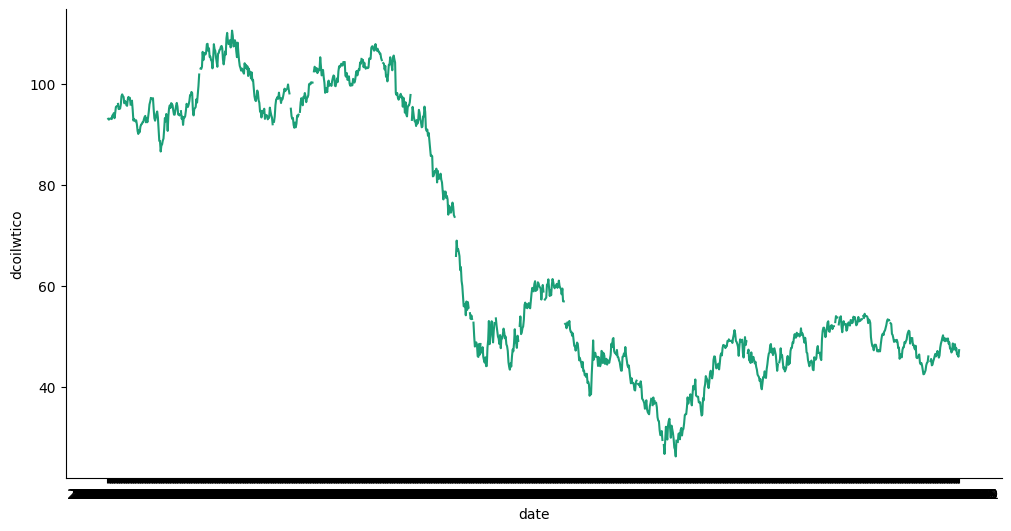

In [ ]:
# @title date vs dcoilwtico

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['dcoilwtico']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = oil.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('dcoilwtico')

In [5]:
store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
holidays_events.head(20)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [8]:
holidays = holidays_events[holidays_events['transferred'] == False]

# Display the filtered DataFrame
holidays.head(20)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [9]:
# prompt: in dataset hoildays remove the col 'transferred' , 'description'	 and encode the col 'type'	,'locale',	'locale_name	'

# Remove columns 'transferred' and 'description'
holidays = holidays.drop(['transferred', 'description'], axis=1)

# Encode categorical columns using one-hot encoding



In [10]:
# prompt: in holidays print all the colcumns name

print(holidays.columns)


Index(['date', 'type', 'locale', 'locale_name'], dtype='object')


In [11]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [12]:
train= pd.read_csv('/content/train.csv')
 # Changed 'date' to 'Date'
train.info()
train.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [13]:
train=train.merge(store, on='store_nbr', how='left')
train = train.merge(oil, on ='date', how='left')

train=train.merge(holidays,on='date' , how ='left')
train["date"] = pd.to_datetime(train.date)
train.info()
train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 14 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   city         object        
 7   state        object        
 8   type_x       object        
 9   cluster      int64         
 10  dcoilwtico   float64       
 11  type_y       object        
 12  locale       object        
 13  locale_name  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(7)
memory usage: 326.2+ MB


,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba


In [14]:
table=PrettyTable()
num_stores = train['store_nbr'].nunique()
num_products = train['family'].nunique()
num_state = train['state'].nunique()
num_cities = train['city'].nunique()
num_locale_name = train['locale_name'].nunique()

# Create a pretty table to display the results

table.field_names = ["Category", "Count"]
table.add_row(["Stores", num_stores])
table.add_row(["Products", num_products])
table.add_row(["States", num_state])
table.add_row(["Cities", num_cities])
table.add_row(["Locale Names", num_locale_name])

# Customize the table formatting
table.align["Category"] = "l"
table.align["Count"] = "r"
table.title = "Summary of Train Data"
table.title_style = "bold magenta"
table.header_style = "upper"
table.border_style = "double"
table.color_rows = ["red"]
table.color_border = "blue"

# Print the table
print(table)

+-----------------------+
| Summary of Train Data |
+--------------+--------+
| CATEGORY     |  COUNT |
+--------------+--------+
| Stores       |     54 |
| Products     |     33 |
| States       |     16 |
| Cities       |     22 |
| Locale Names |     24 |
+--------------+--------+


In [15]:
print(train.columns)


Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_x', 'cluster', 'dcoilwtico', 'type_y', 'locale',
       'locale_name'],
      dtype='object')


In [16]:
train.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
city,0
state,0
type_x,0
cluster,0


We see that column oil price and holiday have lots of missing values. To handle that:

Interpolate column oil price.
A binary column for holiday, as 1-holiday and 0-no holiday.

In [18]:
train['dcoilwtico'] = train['dcoilwtico'].interpolate(limit_direction = 'both')
train.isna().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
city,0
state,0
type_x,0
cluster,0


In [19]:
train['holiday'] = train['type_y'].notnull().astype(int)
train.sample(10)

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,holiday
2732713,2686381,2017-02-20,34,HOME AND KITCHEN II,59.000,1,Guayaquil,Guayas,B,6,53.920178,NaN,NaN,NaN,0
2956132,2908018,2017-06-24,52,PERSONAL CARE,393.000,8,Manta,Manabi,A,11,42.944059,NaN,NaN,NaN,0
2569384,2524834,2016-11-20,51,BOOKS,3.000,0,Guayaquil,Guayas,A,17,47.349453,NaN,NaN,NaN,0
1755289,1730341,2015-09-01,1,LADIESWEAR,18.000,0,Quito,Pichincha,D,13,45.380000,NaN,NaN,NaN,0
2613269,2568719,2016-12-15,32,SEAFOOD,0.000,0,Guayaquil,Guayas,C,3,50.900000,NaN,NaN,NaN,0
841167,832257,2014-04-14,10,PRODUCE,0.000,0,Quito,Pichincha,C,15,104.050000,Holiday,Local,Libertad,1
2714399,2668067,2017-02-10,20,HOME APPLIANCES,0.000,0,Quito,Pichincha,B,6,53.840000,NaN,NaN,NaN,0
388236,381108,2013-08-02,51,MEATS,980.733,0,Guayaquil,Guayas,A,17,106.940000,NaN,NaN,NaN,0
1076665,1060627,2014-08-20,19,CLEANING,893.000,2,Guaranda,Bolivar,C,15,96.400000,NaN,NaN,NaN,0
1184123,1168085,2014-10-19,33,HOME APPLIANCES,0.000,0,Quevedo,Los Rios,C,3,82.770177,NaN,NaN,NaN,0


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 15 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   city         object        
 7   state        object        
 8   type_x       object        
 9   cluster      int64         
 10  dcoilwtico   float64       
 11  type_y       object        
 12  locale       object        
 13  locale_name  object        
 14  holiday      int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(7)
memory usage: 349.5+ MB


In [ ]:
train.describe()

,id,date,store_nbr,sales,onpromotion,cluster,dcoilwtico
count,3.054348e+06,3054348,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,2.099196e+06
mean,1.504277e+06,2015-04-26 12:11:45.717619200,2.750000e+01,3.590209e+02,2.617480e+00,8.481481e+00,6.801587e+01
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.619000e+01
25%,7.546768e+05,2014-03-01 00:00:00,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,4.641000e+01
50%,1.507572e+06,2015-04-28 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00,5.343000e+01
75%,2.255120e+06,2016-06-22 00:00:00,4.100000e+01,1.960110e+02,0.000000e+00,1.300000e+01,9.581000e+01
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,1.106200e+02
std,8.662610e+05,NaN,1.558579e+01,1.107286e+03,1.225494e+01,4.649735e+00,2.569134e+01


**EDA**


Questions¶

* Does the type of stores affect the store sales?

* Which family is having the highest sales?


* Do holidays make the sales better?

* how does oil price fluctuation effect store sales?

*  how does onpromotion fluctuation effect store sales?

> visuallizuing sale


Which family is having the highest sales?

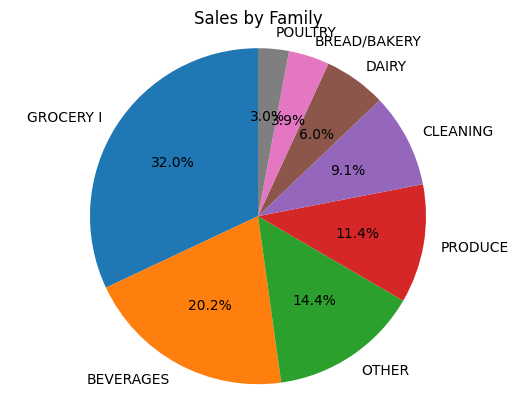

In [37]:
family_sales= train.groupby('family')['sales'].sum().sort_values(ascending=False)
family_sales['OTHER'] = family_sales.iloc[7:].sum()
family_sales = family_sales.sort_values(ascending=False).head(8)
plt.pie(family_sales, labels=family_sales.index, autopct='%1.1f%%', startangle=90)
plt.title('Sales by Family')
plt.axis('equal')
plt.show()


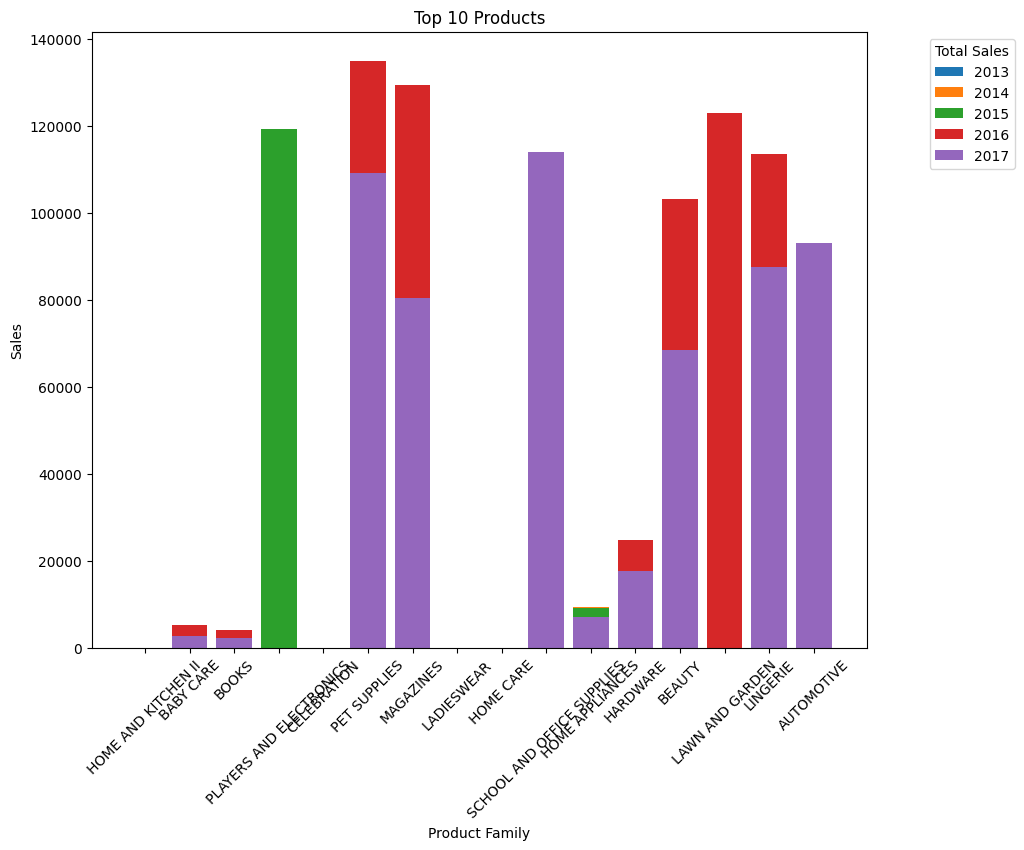

In [27]:
'''train['year']=train['date'].dt.year
sales_by_year_and_product=train.groupby(['year','family'])['sales'].sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 8))

# loop over the years and plot the top 10 products for each year
for year in sales_by_year_and_product["year"].unique():
    top_products = sales_by_year_and_product[sales_by_year_and_product["year"] == year].sort_values(by=['sales'], ascending=True).head(10)
    ax.bar(top_products["family"], top_products["sales"], label=str(year))

# set the axis labels and legend
ax.set_xlabel("Product Family")
ax.set_ylabel("Sales")
ax.legend(title="Total Sales", loc="upper right", bbox_to_anchor=(1.2, 1))

# rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# set the title and show the plot
ax.set_title("Top 10 Products")
plt.show()'''

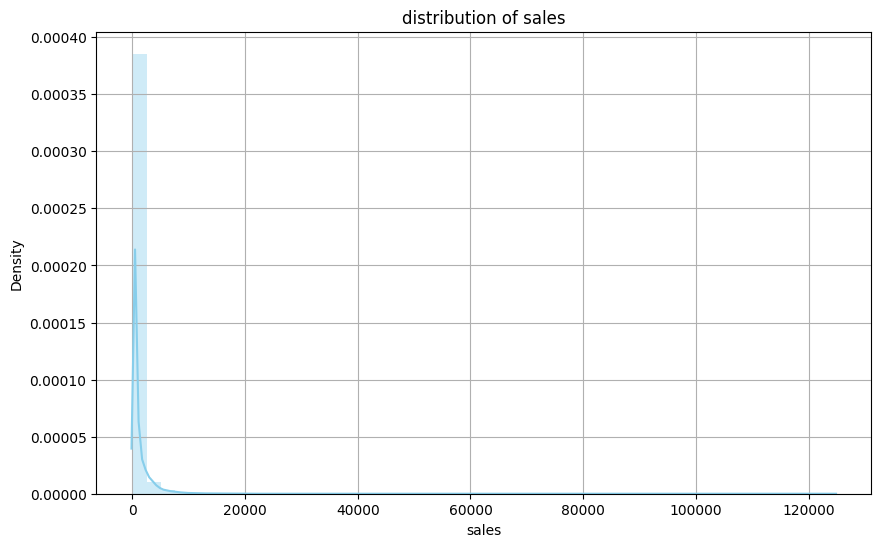

In [38]:
plt.figure(figsize=(10,6))
sns.distplot(train['sales'], kde=True, color='skyblue')
plt.title('distribution of sales')
plt.xlabel('sales')
plt.ylabel('Density')
plt.grid(True)
plt.show()

The sales values are highly skewed and imbalanced. Upon visual inspection, the graph appears to be very one-sided, indicating a strong right skewness in the distribution.

In [39]:
sales_stats = train['sales'].describe()
print(sales_stats)
# Skewness
sales_skewness = train['sales'].skew()

# Kurtosis
sales_kurtosis = train['sales'].kurtosis()

print("Skewness:", sales_skewness)
print("Kurtosis:", sales_kurtosis)

count    3.054348e+06
mean     3.590209e+02
std      1.107286e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.960110e+02
max      1.247170e+05
Name: sales, dtype: float64
Skewness: 7.499911774865158
Kurtosis: 165.0684453249542


* Standard Deviation: The sales data has a high standard deviation of approximately $1,102. This indicates a large amount of variability in the sales values.
*  Minimum: The minimum sales value is 0, meaning there are observations with no sales.
*  25th Percentile (Q1): 25% of the sales data falls below 0, indicating a significant portion of observations with no sales.
*  Median (50th Percentile): The median sales value is 11, which is considerably lower than the mean. This suggests that the distribution is right-skewed.
*  75th Percentile (Q3): 75% of the sales data falls below 195.85, indicating that most observations have relatively low sales values
*   The given skewness and kurtosis values suggest that the data distribution is highly asymmetrical with a long right tail and a sharp peak, indicating a large number of outliers. This could be due to some extreme values in the dataset.



---



> sales with repect of time



Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_x', 'cluster', 'dcoilwtico', 'type_y', 'locale',
       'locale_name', 'holiday', 'year'],
      dtype='object')


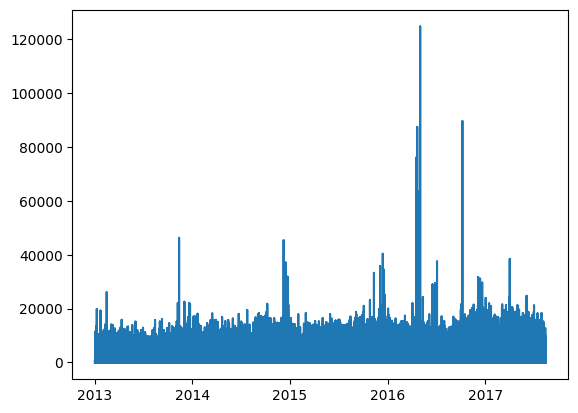

In [40]:
plt.plot(train['date'],train['sales'],label='sales')
print(train.columns)


The phenomenon of high sales at the end of each year, such as around Christmas, is generally considered a seasonal pattern.



---



Does the type of stores affect the store sales?

> Sales  by month

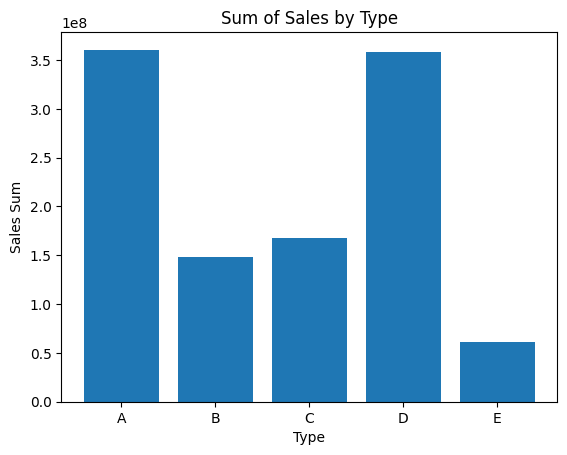

In [43]:
sales_sum_by_type = train.groupby('type_x')['sales'].sum()
plt.bar(sales_sum_by_type.index, sales_sum_by_type.values)
plt.xlabel('Type')
plt.ylabel('Sales Sum')
plt.title('Sum of Sales by Type')
plt.show()

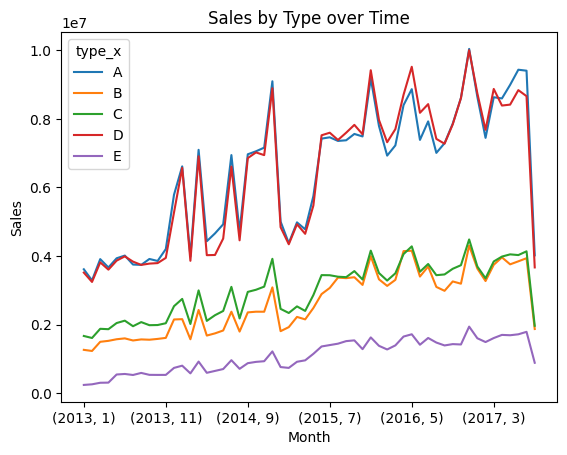

In [45]:
train['month']= train['date'].dt.month
train['year']=train['date'].dt.year
#group by month and year
monthly_sales_by_type = train.groupby(['year','month', 'type_x'])['sales'].sum()

# Unstack 'type' to have types as columns
pivot_df = monthly_sales_by_type.unstack(level='type_x')

# Plot the time series for each type
pivot_df.plot()

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by Type over Time')

# Display the plot
plt.show()

Answer: Types of stores affect the sales. Here we can see type A and D have highest sales throughout the period, then type C, B and lastly type E.



---

how does onpromotion fluctuation effect store sales?



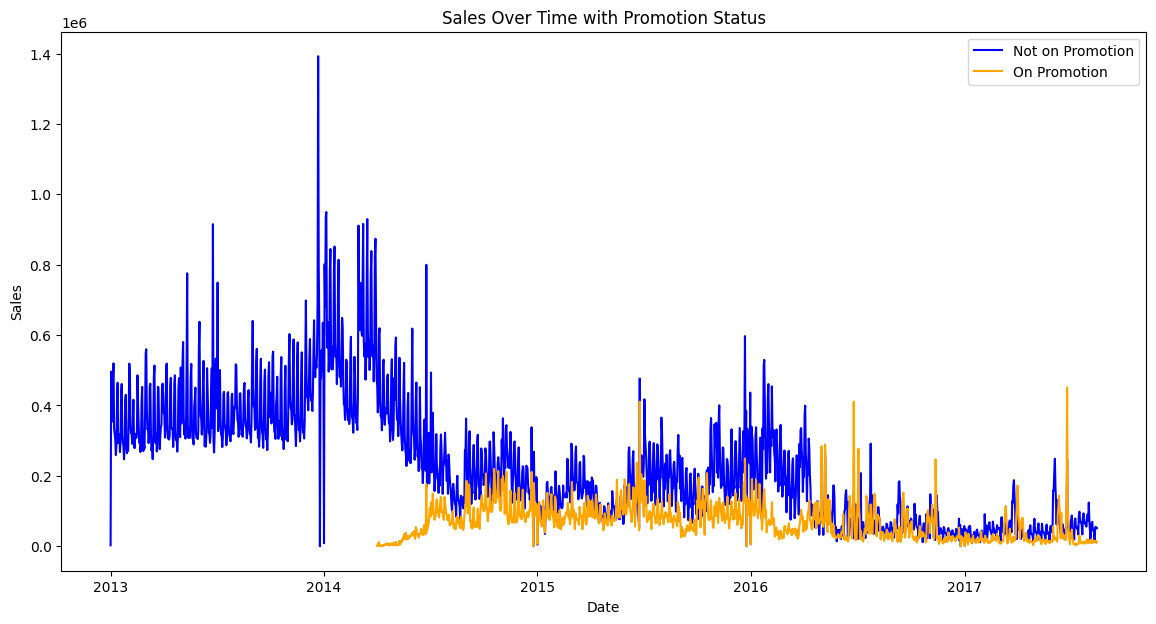

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_x', 'cluster', 'dcoilwtico', 'type_y', 'locale',
       'locale_name', 'holiday', 'year', 'month'],
      dtype='object')


In [46]:
# Convert 'date' to datetime
train['date'] = pd.to_datetime(train['date'])

# Make a copy of the DataFrame with 'date' as the index
train_with_index = train.set_index('date')

plt.figure(figsize=(14, 7))

# Plot sales for items not on promotion
plt.plot(train_with_index[train_with_index['onpromotion'] == 0].resample('D').sum()['sales'], label='Not on Promotion', color='blue')

# Plot sales for items on promotion
plt.plot(train_with_index[train_with_index['onpromotion'] == 1].resample('D').sum()['sales'], label='On Promotion', color='orange')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time with Promotion Status')
plt.legend()
plt.show()

print(train.columns)  # This will still show the original columns


*  Promotions seem to start becoming more frequent or recorded around 2014, showing an increase in promotional activities.
*  Both lines exhibit periodic peaks and troughs, which could indicate seasonal effects on sales. but still need more info


In [47]:
daily_sales = train.groupby('date')[['sales', 'holiday', 'onpromotion']].sum()
daily_sales['oil_price'] = train.groupby('date')['dcoilwtico'].mean()
daily_sales.head()

,sales,holiday,onpromotion,oil_price
date,,,,
2013-01-01,2511.618999,1782,0,93.140000
2013-01-02,496092.417944,0,0,93.140000
2013-01-03,361461.231124,0,0,92.970000
2013-01-04,354459.677093,0,0,93.120000
2013-01-05,477350.121229,1782,0,93.140006


In [48]:
daily_sales.loc[daily_sales['holiday'] > 0, 'holiday'] = 1
daily_sales.head()

,sales,holiday,onpromotion,oil_price
date,,,,
2013-01-01,2511.618999,1,0,93.140000
2013-01-02,496092.417944,0,0,93.140000
2013-01-03,361461.231124,0,0,92.970000
2013-01-04,354459.677093,0,0,93.120000
2013-01-05,477350.121229,1,0,93.140006


<Axes: >

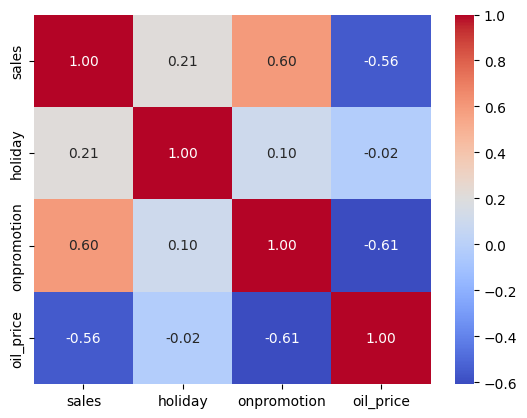

In [49]:
# Create a heat map
correlation_matrix = daily_sales.corr()

# Create a heat map of the correlation matrix
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")

The Spearman correlation coefficient of
0.538
0.538 indicates a moderate positive correlation between sales and the onpromotion status. This means that as the number of promotions increases, sales also tend to increase, though the relationship is not perfectly linear.

Testing the stationarity of a time series using the Augmented Dickey-Fuller (ADF) test from the statsmodels library:

In [50]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,holiday,year,month
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,1,2013,1
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,1,2013,1
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,1,2013,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,1,2013,1
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,1,2013,1


In [51]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']

    # Extract and print the results with corresponding labels
    output = {label: value for label, value in zip(labels, result[:4])}

    for key, value in output.items():
        print(f'{key}: {value}')

    # Print critical values
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    # Check the p-value to determine stationarity
    p_value = result[1]
    if p_value <= 0.05:
        print("Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary.")
    else:
        print("Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary.")




In [52]:
ts=daily_sales['sales']
adfuller_test(ts)

ADF Test Statistic: -2.931645840399923
p-value: 0.041789840054320695
#Lags Used: 23
Number of Observations Used: 1660
Critical Values:
   1%: -3.4342954463097706
   5%: -2.8632826898390484
   10%: -2.5676977663666714
Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary.


After snooping down there trying to come up with good models, I realised that Chrismas date is missing :))))) I'm just speechless.

In [53]:
daily_sales = daily_sales.asfreq('D')
daily_sales[daily_sales.isnull().any(axis=1)]

,sales,holiday,onpromotion,oil_price
date,,,,
2013-12-25,NaN,NaN,NaN,NaN
2014-12-25,NaN,NaN,NaN,NaN
2015-12-25,NaN,NaN,NaN,NaN
2016-12-25,NaN,NaN,NaN,NaN


In [54]:
# Fill NaN value

daily_sales = daily_sales.asfreq('D')
daily_sales['sales'] = daily_sales['sales'].fillna(0)
daily_sales['holiday'] = daily_sales['holiday'].fillna(1)
daily_sales['onpromotion'] = daily_sales['onpromotion'].fillna(0)

# oil_price:
daily_sales['oil_price'] = daily_sales['oil_price'].interpolate(limit_direction = 'both')

daily_sales.isna().sum()

,0
sales,0
holiday,0
onpromotion,0
oil_price,0


In [55]:
monthly_sales = daily_sales.resample('M').sum()
monthly_sales.head()

,sales,holiday,onpromotion,oil_price
date,,,,
2013-01-31,1.032762e+07,3.0,0.0,2935.870000
2013-02-28,9.658960e+06,2.0,0.0,2672.080000
2013-03-31,1.142850e+07,1.0,0.0,2890.360000
2013-04-30,1.099346e+07,5.0,0.0,2754.140000
2013-05-31,1.198556e+07,4.0,0.0,2935.749967


In [56]:
ts=monthly_sales['sales']
adfuller_test(ts)

ADF Test Statistic: -2.2083265793432174
p-value: 0.2032372810917497
#Lags Used: 1
Number of Observations Used: 54
Critical Values:
   1%: -3.55770911573439
   5%: -2.9167703434435808
   10%: -2.59622219478738
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary.


In [ ]:
train1 = train.groupby('date')[['sales','onpromotion']].sum().reset_index() # Changed tuple to list
print(train1)

           date          sales  onpromotion
0    2013-01-01    2511.618999            0
1    2013-01-02  496092.417944            0
2    2013-01-03  361461.231124            0
3    2013-01-04  354459.677093            0
4    2013-01-05  477350.121229            0
...         ...            ...          ...
1679 2017-08-11  826373.722022        14179
1680 2017-08-12  792630.535079         8312
1681 2017-08-13  865639.677471         9283
1682 2017-08-14  760922.406081         8043
1683 2017-08-15  762661.935939        10605

[1684 rows x 3 columns]


Text(0.5, 1.0, 'Residual Plot')

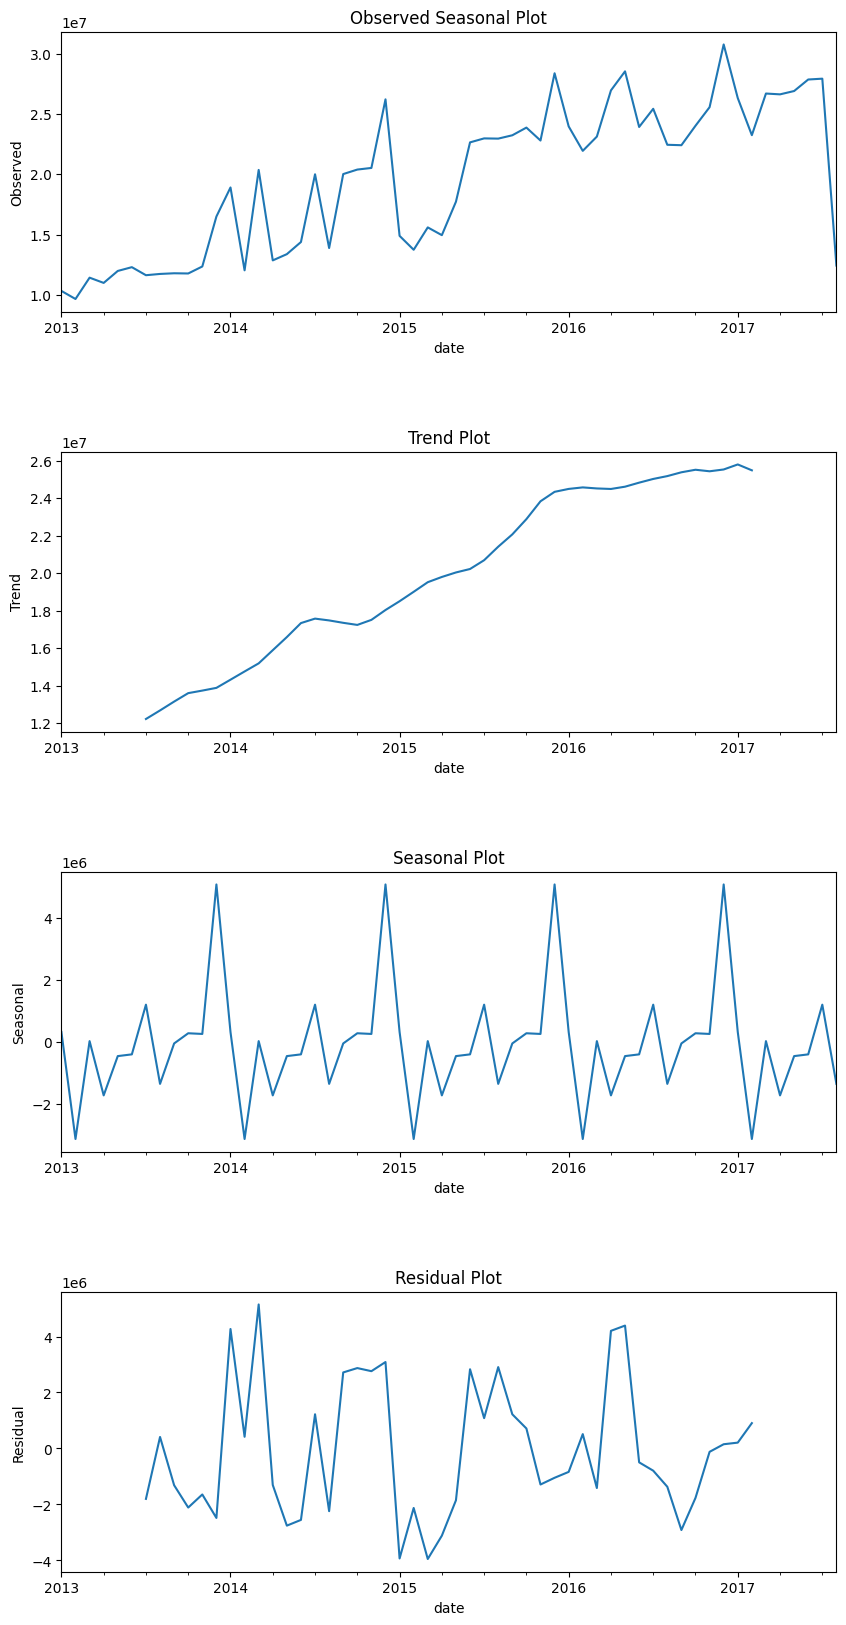

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose the time series
decomposition = seasonal_decompose(monthly_sales['sales'], model='additive', period=12)

# create a seasonal plot
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,20))
fig.subplots_adjust(hspace=0.5) # added space between subplots

decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
axes[0].set_title('Observed Seasonal Plot')

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
axes[1].set_title('Trend Plot')
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
axes[2].set_title('Seasonal Plot')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_title('Residual Plot')

Text(0.5, 1.0, 'Residual Plot')

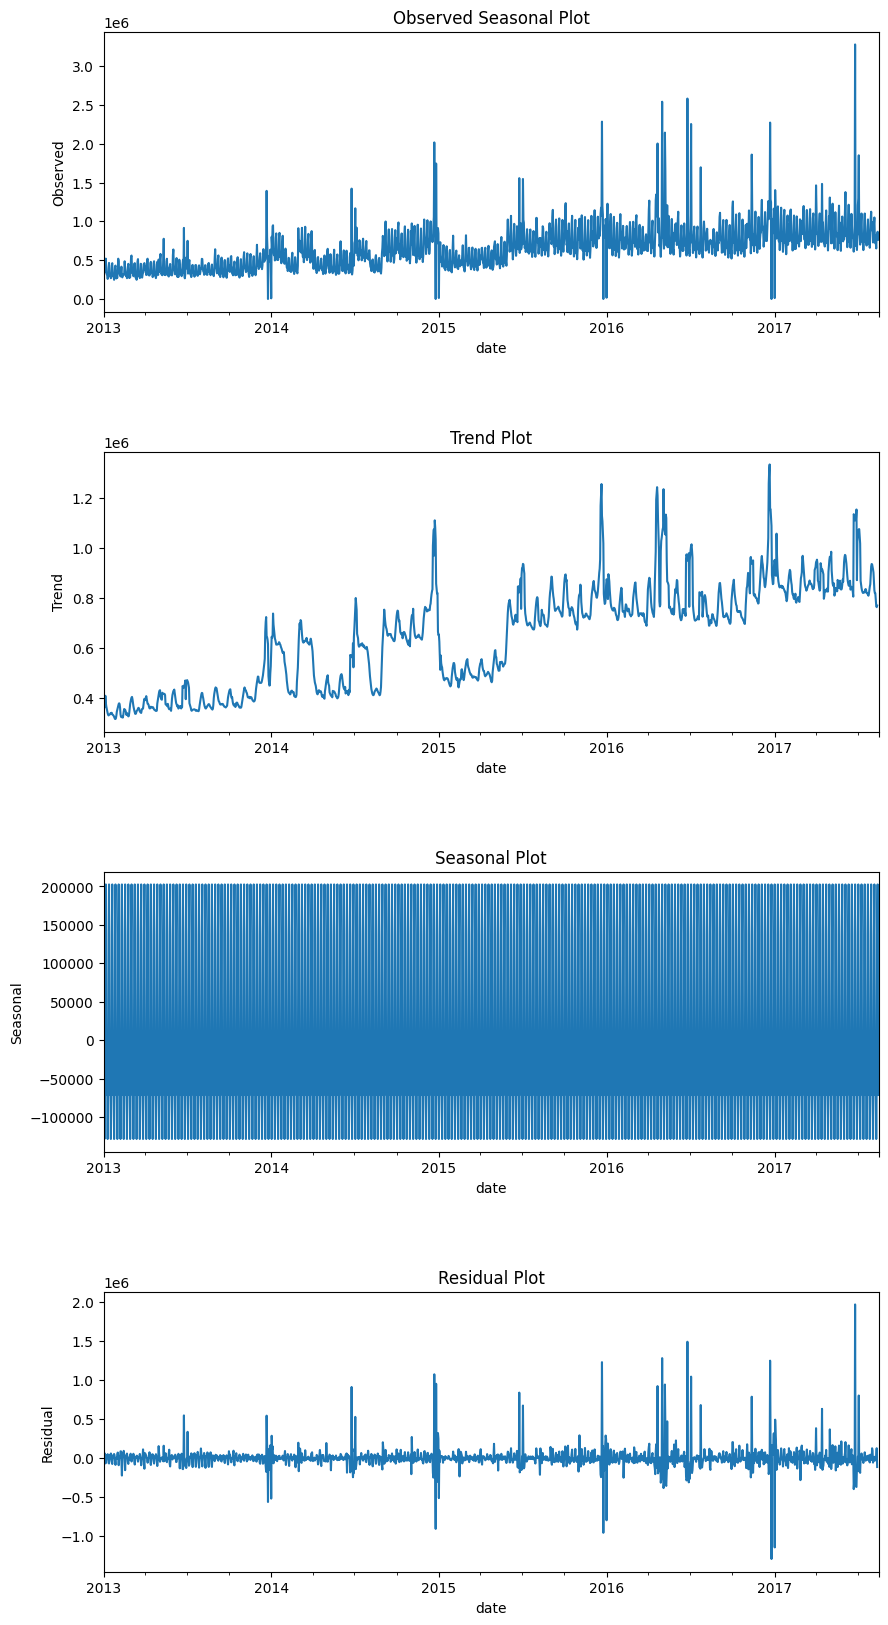

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose the time series
decomposition = seasonal_decompose(daily_sales['sales'], model='additive', period=7)

# create a seasonal plot
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,20))
fig.subplots_adjust(hspace=0.5) # added space between subplots

decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
axes[0].set_title('Observed Seasonal Plot')

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
axes[1].set_title('Trend Plot')
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
axes[2].set_title('Seasonal Plot')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_title('Residual Plot')

The time series of monthly data doesn't look very stationary if i compair to daily data, I guess there's a slight upward trend and seasonality.

For monthly data, there is an increasing trend in November and December, then followed by dips in January and Feburary next year.

To identify the order of AR and MA terms, you can use the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots

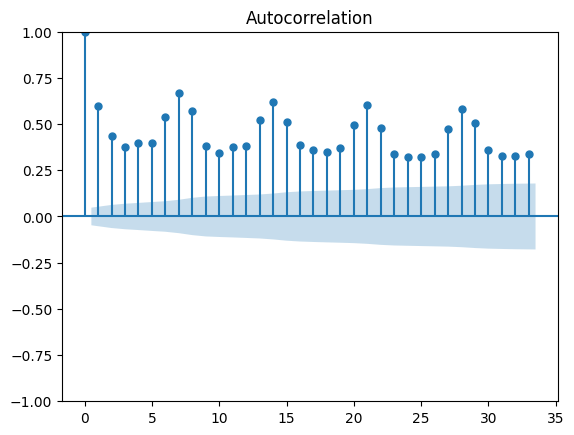

In [60]:
plot_acf(daily_sales['sales'], alpha = 0.05);

We have a correlation with 1 and 7 day sales in the past;

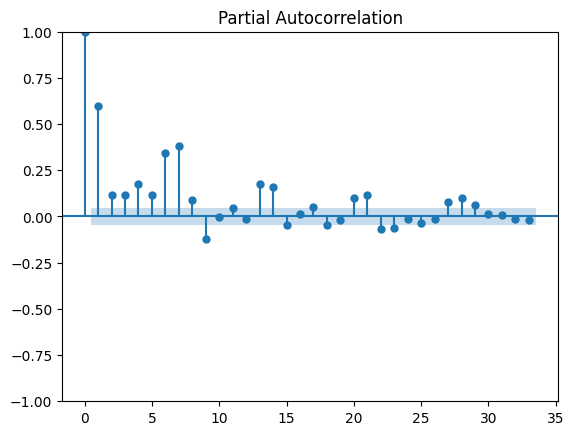

In [61]:
plot_pacf(daily_sales['sales'], alpha = 0.05);

As we can see, we have a seasonal pattern on day 7 and 16, that is, for every 6-7 days we have an increase in sales. So we know that D = 1, m = 7 as weekly differencing and after that we have stationarity.

**Run SARIMAX**

Let's run a grid search to see which parameter combination fits.

In [63]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.8 MB/s eta 0:00:00


In [64]:

import pmdarima as pm

stepwise_model = pm.auto_arima(daily_sales['sales'],
                               exog=daily_sales[['holiday', 'onpromotion', 'oil_price']],
                            start_p=2, start_q=0,
                           max_p=3, max_q=2, m=7, # p,q = 1, 2, 3
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,0,0)(0,1,1)[7] intercept   : AIC=inf, Time=5.88 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=46228.751, Time=0.35 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=45859.970, Time=4.53 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=45583.078, Time=5.43 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=46226.860, Time=0.11 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=46206.371, Time=1.41 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=8.99 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=inf, Time=10.44 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=45869.562, Time=3.49 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=28.97 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=45655.884, Time=2.45 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=45528.434, Time=4.67 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=46190.138, Time=1.25 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=5.21 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=inf, 

In [65]:
order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order
print('order: ',order)
print('seasonal order: ',seasonal_order)

order:  (1, 0, 1)
seasonal order:  (0, 1, 1, 7)


In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# fit SARIMA based on helper plots
sar = SARIMAX(daily_sales['sales'],
              exog=daily_sales[['holiday', 'onpromotion', 'oil_price']], #Exclude  'transactions'
                order=order,
                seasonal_order=seasonal_order, #(P, Q, D)
                trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1688
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood              -22133.598
Date:                           Mon, 30 Sep 2024   AIC                          44283.196
Time:                                   06:50:25   BIC                          44326.614
Sample:                               01-01-2013   HQIC                         44299.279
                                    - 08-15-2017                                         
Covariance Type:                             opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept    -711.0284    560.828     -1.268      0.205   -1810.231     388.174
holiday      6.508e+04   1.04e+04      6.260      0.000    4.47e+04    8.55e+04
onpromotion    74.9368      1.215     61.683      0.000      72.556      77.318
oil_price    -321.1544   2257.536     -0.142      0.887   -4745.844    4103.536
ar.L1           0.8554      0.021     40.713      0.000       0.814       0.897
ma.L1          -0.4632      0.033    -14.172      0.000      -0.527      -0.399
ma.S.L7        -0.8133      0.019    -43.171      0.000      -0.850      -0.776
sigma2       2.293e+10      0.094   2.43e+11      0.000    2.29e+10    2.29e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):             23622.78
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                             1.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.37e+26. Standard errors may be unstable.
"""

In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# fit SARIMA based on helper plots
sar = SARIMAX(daily_sales['sales'],
              exog=daily_sales[['holiday', 'onpromotion', 'oil_price']], #Exclude  'transactions'
                order=order,
                seasonal_order=seasonal_order, #(P, Q, D)
                trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1688
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood              -22133.598
Date:                           Mon, 30 Sep 2024   AIC                          44283.196
Time:                                   06:50:29   BIC                          44326.614
Sample:                               01-01-2013   HQIC                         44299.279
                                    - 08-15-2017                                         
Covariance Type:                             opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept    -711.0284    560.828     -1.268      0.205   -1810.231     388.174
holiday      6.508e+04   1.04e+04      6.260      0.000    4.47e+04    8.55e+04
onpromotion    74.9368      1.215     61.683      0.000      72.556      77.318
oil_price    -321.1544   2257.536     -0.142      0.887   -4745.844    4103.536
ar.L1           0.8554      0.021     40.713      0.000       0.814       0.897
ma.L1          -0.4632      0.033    -14.172      0.000      -0.527      -0.399
ma.S.L7        -0.8133      0.019    -43.171      0.000      -0.850      -0.776
sigma2       2.293e+10      0.094   2.43e+11      0.000    2.29e+10    2.29e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):             23622.78
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                             1.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.37e+26. Standard errors may be unstable.
"""

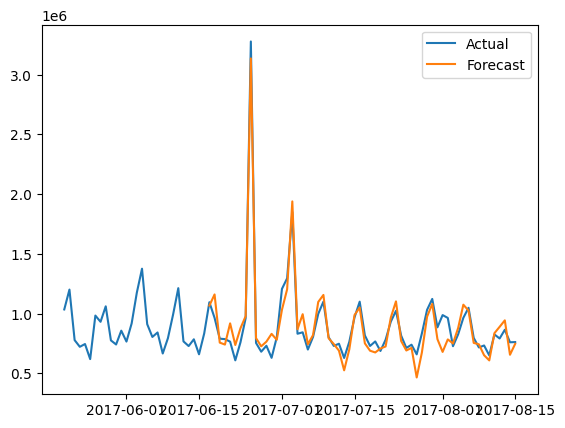

In [70]:
last_60_days = daily_sales.iloc[-60:]

# Extract the exogenous variables for the last 60 days
exog_data = last_60_days[['holiday', 'onpromotion', 'oil_price']]

# Get the forecast for the next 60 days, including exogenous variables
forecast = sar.get_prediction(start=last_60_days.index[0], end=last_60_days.index[-1], exog=exog_data)

# Extract the predicted values for the next 60 days
predicted_values = forecast.predicted_mean

# Plot the actual sales and predicted values
plt.plot(daily_sales[1600:]['sales'], label = 'Actual')
plt.plot(predicted_values.index, predicted_values, label='Forecast')
plt.legend()
plt.show()

In [161]:
Oil=oil.copy()

In [162]:
Oil.tail()

,date,dcoilwtico
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


In [163]:
test=pd.read_csv('/content/test.csv')
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [164]:
test.tail()

,id,date,store_nbr,family,onpromotion
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9
28511,3029399,2017-08-31,9,SEAFOOD,0


test=test.merge(oil,on='date',how ='left')
test=test.merge(holidays,on='date',how ='left')
test.head()

In [165]:
test=test.merge(Oil,on='date',how ='left')
test=test.merge(holidays,on='date',how ='left')
test.head()

,id,date,store_nbr,family,onpromotion,dcoilwtico,type,locale,locale_name
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.8,NaN,NaN,NaN
1,3000889,2017-08-16,1,BABY CARE,0,46.8,NaN,NaN,NaN
2,3000890,2017-08-16,1,BEAUTY,2,46.8,NaN,NaN,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,46.8,NaN,NaN,NaN
4,3000892,2017-08-16,1,BOOKS,0,46.8,NaN,NaN,NaN


In [166]:
test.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
onpromotion,0
dcoilwtico,7128
type,26730
locale,26730
locale_name,26730


In [167]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           28512 non-null  int64  
 1   date         28512 non-null  object 
 2   store_nbr    28512 non-null  int64  
 3   family       28512 non-null  object 
 4   onpromotion  28512 non-null  int64  
 5   dcoilwtico   21384 non-null  float64
 6   type         1782 non-null   object 
 7   locale       1782 non-null   object 
 8   locale_name  1782 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.0+ MB


test['holiday']= test['type_y'].notnull().astype(int)
test.sample(10)

In [168]:
test['holiday']= test['type'].notnull().astype(int)
test.sample(10)

,id,date,store_nbr,family,onpromotion,dcoilwtico,type,locale,locale_name,holiday
25927,3026815,2017-08-30,36,"LIQUOR,WINE,BEER",7,45.96,NaN,NaN,NaN,0
10402,3011290,2017-08-21,50,CLEANING,11,47.39,NaN,NaN,NaN,0
7287,3008175,2017-08-20,13,PLAYERS AND ELECTRONICS,0,NaN,NaN,NaN,NaN,0
16852,3017740,2017-08-25,31,"LIQUOR,WINE,BEER",2,47.65,NaN,NaN,NaN,0
12841,3013729,2017-08-23,2,BOOKS,0,48.45,NaN,NaN,NaN,0
15901,3016789,2017-08-24,54,POULTRY,0,47.24,Holiday,Local,Ambato,1
95,3000983,2017-08-16,11,PREPARED FOODS,0,46.80,NaN,NaN,NaN,0
1180,3002068,2017-08-16,41,PERSONAL CARE,17,46.80,NaN,NaN,NaN,0
13127,3014015,2017-08-23,27,PET SUPPLIES,0,48.45,NaN,NaN,NaN,0
11823,3012711,2017-08-22,40,DELI,8,47.65,NaN,NaN,NaN,0


In [169]:
test['dcoilwtico']=test['dcoilwtico'].interpolate(limit_direction = 'both')
test.isna().sum()

,0
id,0
date,0
store_nbr,0
family,0
onpromotion,0
dcoilwtico,0
type,26730
locale,26730
locale_name,26730
holiday,0


In [170]:
test['oil_price']= test.groupby('date')['dcoilwtico'].mean()
test=test.groupby('date')[['onpromotion','holiday']].sum()

test.head()

,onpromotion,holiday
date,,
2017-08-16,30539,0
2017-08-17,7505,0
2017-08-18,13777,0
2017-08-19,8614,0
2017-08-20,9513,0


In [171]:
# prompt: add a new columns in test oil_price with recpect date

test['oil_price'] = test.index.map(Oil.set_index('date')['dcoilwtico'])


In [172]:
test.head()

,onpromotion,holiday,oil_price
date,,,
2017-08-16,30539,0,46.80
2017-08-17,7505,0,47.07
2017-08-18,13777,0,48.59
2017-08-19,8614,0,NaN
2017-08-20,9513,0,NaN


In [173]:
daily_sales.head()

,sales,holiday,onpromotion,oil_price
date,,,,
2013-01-01,2511.618999,1.0,0.0,93.140000
2013-01-02,496092.417944,0.0,0.0,93.140000
2013-01-03,361461.231124,0.0,0.0,92.970000
2013-01-04,354459.677093,0.0,0.0,93.120000
2013-01-05,477350.121229,1.0,0.0,93.140006


In [174]:
test.isnull().sum()

,0
onpromotion,0
holiday,0
oil_price,4


In [175]:
# prompt: replacethe null value in test of col oil_price by mean of it

test['oil_price'] = test['oil_price'].fillna(test['oil_price'].mean())
test.head()


,onpromotion,holiday,oil_price
date,,,
2017-08-16,30539,0,46.800000
2017-08-17,7505,0,47.070000
2017-08-18,13777,0,48.590000
2017-08-19,8614,0,47.243333
2017-08-20,9513,0,47.243333


In [176]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 2017-08-16 to 2017-08-31
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   onpromotion  16 non-null     int64  
 1   holiday      16 non-null     int64  
 2   oil_price    16 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 512.0+ bytes


sr

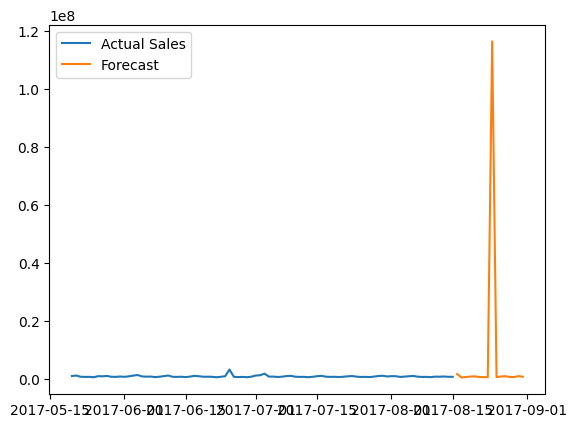

In [179]:
# Extract the exogenous variables for the last 60 days
test.index = pd.to_datetime(test.index)
exog_data = test[['holiday', 'onpromotion', 'oil_price']]

# Assuming daily_sales has a DateTimeIndex:
# Get the start and end dates for prediction
start_date = test.index[-16]  # Start from the last date in daily_sales
end_date = start_date + pd.DateOffset(days=15) # Predict for the next 16 days


# Get the forecast for the next 16 days, including exogenous variables
# Use loc to select data from exog_data based on date range
forecast = sar.get_prediction(start=start_date,
                               end=end_date,
                               exog=exog_data.loc[start_date:end_date,
                                                   ['holiday', 'onpromotion', 'oil_price']])

# Extract the predicted values for the next 16 days
predicted_values = forecast.predicted_mean

# Plot the actual sales and predicted values
# Adjust plotting to use predicted values
plt.plot(daily_sales[1600:]['sales'], label='Actual Sales')  # Assuming you want to plot the last 88 values
plt.plot(predicted_values.index, predicted_values.values, label='Forecast') # Plot predicted values with their index
plt.legend()
plt.show()

In [ ]:
# Assume predicted_values contains your sales predictions

# Load sample_submission to get the 'id' column
sample_submission = pd.read_csv('/content/sample_submission.csv')

# Create a DataFrame for submission
submission5 = pd.DataFrame({'id': sample_submission['id'], 'sales': predicted_values.values})

# Save to CSV
submission5.to_csv('submission5.csv', index=False)